In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt



In [6]:
df = pd.read_csv("yield_df.csv")
df

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...,...
28237,28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [8]:
# Step 1: Drop the 'Unnamed: 0' column as it is unnecessary
df = df.drop(columns=['Unnamed: 0'])

In [10]:
# Step 2: One-Hot Encoding for categorical columns (Area, Item)
##df_encoded = pd.get_dummies(df, columns=['Area', 'Item'], drop_first=True)
##df_encoded

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to categorical columns
df_encoded = df.copy()

# Columns to encode
columns_to_encode = ['Area', 'Item']

for column in columns_to_encode:
    df_encoded[column] = label_encoder.fit_transform(df[column])

# Show the encoded DataFrame
df_encoded

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,1,1990,36613,1485.0,121.00,16.37
1,0,3,1990,66667,1485.0,121.00,16.37
2,0,4,1990,23333,1485.0,121.00,16.37
3,0,5,1990,12500,1485.0,121.00,16.37
4,0,6,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,100,4,2013,22581,657.0,2550.07,19.76
28238,100,5,2013,3066,657.0,2550.07,19.76
28239,100,6,2013,13142,657.0,2550.07,19.76
28240,100,7,2013,22222,657.0,2550.07,19.76


In [12]:
# Step 4: Remove outliers using IQR method

# Identify and remove outliers using the IQR method for multiple columns
def remove_outliers_multiple_columns_filtered(df, columns):
    bounds = {}
    filtered_df = df.copy()
    
    for column in columns:
        Q1 = filtered_df[column].quantile(0.25)
        Q3 = filtered_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Store bounds for reference
        bounds[column] = {"lower_bound": lower_bound, "upper_bound": upper_bound}
        
        # Filter data to remove outliers for the current column
        filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]
    
    return filtered_df, bounds

columns_to_filter = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
filtered_df, _ = remove_outliers_multiple_columns_filtered(df_encoded, columns_to_filter)
filtered_df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,1,1990,36613,1485.0,121.00,16.37
1,0,3,1990,66667,1485.0,121.00,16.37
2,0,4,1990,23333,1485.0,121.00,16.37
3,0,5,1990,12500,1485.0,121.00,16.37
4,0,6,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,100,4,2013,22581,657.0,2550.07,19.76
28238,100,5,2013,3066,657.0,2550.07,19.76
28239,100,6,2013,13142,657.0,2550.07,19.76
28240,100,7,2013,22222,657.0,2550.07,19.76


In [14]:
# Step 5: Scaling the numerical features (Standardization)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_df[['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']])


In [22]:
# Step 6: Add scaled features back to the dataframe
filtered_df[['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']] = scaled_features
filtered_df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,1,1990,-0.393076,0.49223,-0.907647,-0.681516
1,0,3,1990,0.145105,0.49223,-0.907647,-0.681516
2,0,4,1990,-0.630883,0.49223,-0.907647,-0.681516
3,0,5,1990,-0.824871,0.49223,-0.907647,-0.681516
4,0,6,1990,-0.923360,0.49223,-0.907647,-0.681516
...,...,...,...,...,...,...,...
28237,100,4,2013,-0.644349,-0.64858,-0.816336,-0.144636
28238,100,5,2013,-0.993807,-0.64858,-0.816336,-0.144636
28239,100,6,2013,-0.813374,-0.64858,-0.816336,-0.144636
28240,100,7,2013,-0.650777,-0.64858,-0.816336,-0.144636


In [18]:
# Step 7: Split the data into features (X) and target (y)
X = filtered_df.drop(columns=['hg/ha_yield'])  # Features (excluding target)
y = filtered_df['hg/ha_yield']  # Target variable

In [24]:
# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Step 9: Define the neural network model for regression
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')  # Linear activation for regression
])


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Step 10: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',  # MSE for regression
              metrics=['mean_absolute_error', 'mean_squared_error'])

In [30]:
# Step 11: Define a learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** (epoch // epochs_drop))

lr_scheduler = LearningRateScheduler(lr_schedule)

In [32]:
# Step 12: Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.2,  # Reserve a portion of training data for validation
                    epochs=30, 
                    batch_size=32, 
                    callbacks=[lr_scheduler], 
                    verbose=1)


Epoch 1/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7857 - mean_absolute_error: 1.0355 - mean_squared_error: 1.7857 - val_loss: 9.5366 - val_mean_absolute_error: 2.8914 - val_mean_squared_error: 9.5366 - learning_rate: 0.0010
Epoch 2/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1025 - mean_absolute_error: 0.8357 - mean_squared_error: 1.1025 - val_loss: 10.9773 - val_mean_absolute_error: 3.1629 - val_mean_squared_error: 10.9773 - learning_rate: 0.0010
Epoch 3/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0010 - mean_absolute_error: 0.7954 - mean_squared_error: 1.0010 - val_loss: 1.9937 - val_mean_absolute_error: 1.0191 - val_mean_squared_error: 1.9937 - learning_rate: 0.0010
Epoch 4/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9501 - mean_absolute_error: 0.7722 - mean_squared_error: 0.9501 - val_loss: 2.1963 - val_mean_absolute_error: 1.3715 - val_mean_squared_error: 2.1963 - learning_rate: 0.0010
Epoch 5/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - 

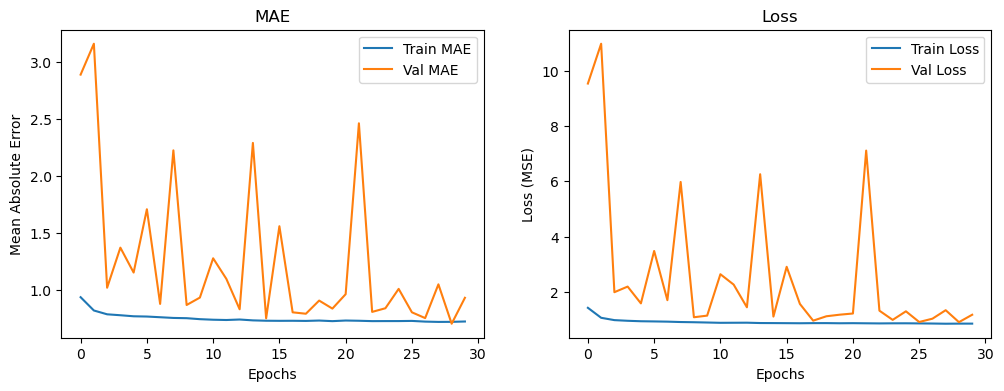

In [33]:
# Step 13: Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Loss')
plt.show()

In [36]:
# Step 14: Evaluate the model on the test data
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test Loss (MSE): 1.2174
Test MAE: 0.9438


In [38]:
# Step 15: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 16: Evaluate using custom metrics (optional)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R-squared: {r2_score(y_test, y_pred):.4f}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error: 1.2174
Mean Absolute Error: 0.9438
R-squared: -0.1722


In [40]:
# Step 17: Save the model (optional)
##model.save("yield_regression_model.h5")

# Step 18: Example predictions
example_index = 5
print(f"True Value: {y_test.iloc[example_index]:.4f}, Predicted Value: {y_pred[example_index][0]:.4f}")

True Value: -0.1601, Predicted Value: -0.0087
